In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def are_there_expected_number_of_cycles(location_df, num_of_detections, cycle_length):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert num_of_detections.shape[0] <= between_time_cycles.shape[0]

In [6]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [7]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [8]:
def get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins):
    """
    Constructs a pandas Series that records the duration of time occupied by bouts observed per interval.
    The used interval is the cycle_length in minutes
    """

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{cycle_length_in_mins}T")['total_bout_duration_in_secs'].sum()

    return bout_duration_per_interval

def get_metric_per_time_on(metric, time_on):

    return metric / (time_on)

def filter_and_prepare_metric(metric, dc_tag, data_params):

    col_name = f"{data_params['metric_tag']} ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(metric.values, index=metric.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["datetime_UTC", col_name])

In [9]:
def does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df):
    assert dc_applied_df.shape[0] < location_df.shape[0]

In [10]:
def does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme):
    assert (metric_for_scheme_for_comparison.loc[metric_for_scheme.index].compare(metric_for_scheme).empty)

def do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison):
    assert metric_for_scheme_for_comparison.values.all() >= 0

In [11]:
def get_associated_metric_for_cont_column(metric_for_scheme, call_rate_cont_column):
    metric_for_scheme_for_comparison = metric_for_scheme.reindex(call_rate_cont_column.index, fill_value=0)
    does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme)
    do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison)

    return metric_for_scheme

def select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params):
    plt_dcmetr = metric_for_scheme_for_comparison.loc[data_params['start']:data_params['end']].copy()
    plt_cmetr = call_rate_cont_column.loc[data_params['start']:data_params['end']].copy()

    return plt_dcmetr, plt_cmetr

In [12]:
def generate_activity_btp_for_dc_schemes(data_params, file_paths):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

    dc_schemes = data_params['dc_tags'][1:]
    cont_scheme = data_params['dc_tags'][0]
    for dc_tag in dc_schemes:
        cycle_length_in_mins = int(dc_tag.split('of')[1])
        time_on_in_mins = int(dc_tag.split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)

        dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, 
                                                            time_on_in_secs, data_params)
        does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)

        bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, time_on_in_mins)
        bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins)
        bout_time_percentage = 100*get_metric_per_time_on(bout_duration, time_on_in_secs)
        bout_time_percentage_dc_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
        bout_time_percentage_dc_column = bout_time_percentage_dc_column.set_index("datetime_UTC")
        are_there_expected_number_of_cycles(dc_applied_df, bout_time_percentage_dc_column, cycle_length_in_mins)

        activity_arr = pd.concat([activity_arr, bout_time_percentage_dc_column], axis=1)

    return activity_arr

def get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params):
    dc_tag_split = re.findall(r"\d+", metric_col_name)
    dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
    cycle_length = int(dc_tag_split[-1])
    cycle_length_in_secs = 60*cycle_length

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
    dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length, 
                                                        cycle_length_in_secs, data_params)
    does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)
    bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, cycle_length)

    bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length)
    bout_time_percentage = 100*get_metric_per_time_on(bout_duration, cycle_length_in_secs)
    bout_time_percentage_cont_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
    bout_time_percentage_cont_column = bout_time_percentage_cont_column.set_index("datetime_UTC")
    are_there_expected_number_of_cycles(location_df, bout_time_percentage_cont_column, cycle_length)

    return bout_time_percentage_cont_column

In [13]:
def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.rcParams.update({'font.size':12})
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time_percentage'):
        plt.xlim(1e-2, 1e3)
        plt.ylim(1e-2, 1e3)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [14]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LFCarp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LFCarp',
 

In [15]:
site_key = 'Carp'
freq_key = 'LF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

In [16]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220727_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [17]:
file_path = Path(files_from_loc[0])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = 'LF'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = 6
data_params['time_on_in_secs'] = 360
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

In [18]:
def construct_bout_metrics_from_classified_dets(fgroups_with_bouttags):
    """
    Reads in the dataframe of detected calls with bout tags.
    Uses these bout tags to create a new dataframe of bout metrics for the start and end times of each bout.
    Also includes the lowest frequency of a call within a bout as the lower bound for the bout
    and the highest frequency of a call within a bout as the upper bound frequency for the bout.
    Now, also included the number of detections captured within each bout.
    """

    location_df = fgroups_with_bouttags.copy()
    location_df.reset_index(drop=True, inplace=True)
    group_of_tagged_dets = location_df['freq_group'].unique().item()

    end_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout end', 'call_end_time'])
    start_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout start', 'call_start_time'])
    ref_end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time_wrt_ref'].astype('float')
    ref_start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time_wrt_ref'].astype('float')
    end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time'].astype('float')
    start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time'].astype('float')
    bout_starts = start_times_of_bouts.index
    bout_ends = end_times_of_bouts.index

    low_freqs = []
    high_freqs = []
    ref_time_cycle_start = []
    ref_time_cycle_end = []
    num_calls_per_bout = []
    for i, bout_start in enumerate(bout_starts):
        bat_bout = location_df.iloc[bout_start:bout_ends[i]+1]
        pass_low_freq = np.min(bat_bout['low_freq'])
        pass_high_freq = np.max(bat_bout['high_freq'])
        start_cycle = bat_bout['cycle_ref_time'].values[0]
        end_cycle = bat_bout['cycle_ref_time'].values[-1]
        num_calls = len(bat_bout)
        low_freqs += [pass_low_freq]
        high_freqs += [pass_high_freq]
        ref_time_cycle_start += [start_cycle]
        ref_time_cycle_end += [end_cycle]
        num_calls_per_bout += [num_calls]

    bout_metrics = pd.DataFrame()
    bout_metrics['start_time_of_bout'] = start_times_of_bouts.values
    bout_metrics['end_time_of_bout'] = end_times_of_bouts.values
    bout_metrics['start_time_wrt_ref'] = ref_start_times.values
    bout_metrics['end_time_wrt_ref'] = ref_end_times.values
    bout_metrics['start_time'] = start_times.values
    bout_metrics['end_time'] = end_times.values
    bout_metrics['low_freq'] = low_freqs
    bout_metrics['high_freq'] = high_freqs
    bout_metrics['freq_group'] = group_of_tagged_dets
    bout_metrics['cycle_ref_time_start'] = ref_time_cycle_start
    bout_metrics['cycle_ref_time_end'] = ref_time_cycle_end
    bout_metrics['number_of_dets'] = num_calls_per_bout
    bout_metrics['bout_duration'] = end_times_of_bouts.values - start_times_of_bouts.values
    bout_metrics['bout_duration_in_secs'] = bout_metrics['bout_duration'].apply(lambda x : x.total_seconds())

    return bout_metrics

In [19]:
def add_placeholder_call_at_end_of_cycle(df):
    end_time_of_last_call = df.loc[len(df)-1, 'call_end_time']
    cycle_time_of_last_call = df.loc[len(df)-1, 'cycle_ref_time']
    next_cycle_time = cycle_time_of_last_call + pd.Timedelta(minutes=data_params['cycle_length'])
    fake_call_start_time = next_cycle_time
    fake_call_end_time = next_cycle_time
    duration_from_last_ms = (next_cycle_time - end_time_of_last_call).total_seconds()*1000
    start_time_wrt_ref = (next_cycle_time - cycle_time_of_last_call).total_seconds()
    end_time_wrt_ref = start_time_wrt_ref

    mod_df = pd.concat([df, pd.DataFrame(df.loc[len(df)-1]).T], axis=0, ignore_index=True)

    mod_df.loc[len(mod_df)-1, 'call_status'] = 'bout end'
    mod_df.loc[len(mod_df)-1, 'change_markers'] = -1
    mod_df.loc[len(mod_df)-1, 'bout_tag'] = 0
    mod_df.loc[len(mod_df)-1, 'duration_from_last_call_ms'] = duration_from_last_ms
    mod_df.loc[len(mod_df)-1, 'start_time_wrt_ref'] = start_time_wrt_ref
    mod_df.loc[len(mod_df)-1, 'end_time_wrt_ref'] = end_time_wrt_ref
    mod_df.loc[len(mod_df)-1, 'ref_time'] = fake_call_start_time
    mod_df.loc[len(mod_df)-1, 'call_start_time'] = fake_call_start_time
    mod_df.loc[len(mod_df)-1, 'call_end_time'] = fake_call_end_time
    mod_df.loc[len(mod_df)-1, 'cycle_ref_time'] = cycle_time_of_last_call
    mod_df.loc[len(mod_df)-1, 'class'] = 'MADE-UP FOR DC INVESTIGATION'

    return mod_df

def add_placeholder_call_at_start_of_cycle(df):
    cycle_time_of_first_call = df.loc[0, 'cycle_ref_time']
    fake_call_start_time = cycle_time_of_first_call
    fake_call_end_time = cycle_time_of_first_call
    duration_from_last_ms = 0
    start_time_wrt_ref = 0
    end_time_wrt_ref = start_time_wrt_ref

    mod_df = pd.concat([pd.DataFrame(df.loc[0]).T, df], axis=0, ignore_index=True)

    mod_df.loc[0, 'call_status'] = 'bout start'
    mod_df.loc[0, 'change_markers'] = 1
    mod_df.loc[0, 'bout_tag'] = 0
    mod_df.loc[0, 'duration_from_last_call_ms'] = duration_from_last_ms
    mod_df.loc[0, 'start_time_wrt_ref'] = start_time_wrt_ref
    mod_df.loc[0, 'end_time_wrt_ref'] = end_time_wrt_ref
    mod_df.loc[0, 'ref_time'] = fake_call_start_time
    mod_df.loc[0, 'call_start_time'] = fake_call_start_time
    mod_df.loc[0, 'call_end_time'] = fake_call_end_time
    mod_df.loc[0, 'cycle_ref_time'] = cycle_time_of_first_call
    mod_df.loc[0, 'class'] = 'MADE-UP FOR DC INVESTIGATION'

    return mod_df

def add_placeholder_to_tag_dets_wrt_cycle(cycle_group):
    df = cycle_group.copy()
    df.reset_index(inplace=True, drop=True)

    first_call_within_another_bout = (df.loc[0, 'call_status']=='within bout')|(df.loc[0, 'call_status']=='bout end')
    if first_call_within_another_bout:
        mod_df = add_placeholder_call_at_start_of_cycle(df)
    else:
        mod_df = df.copy()

    last_call_within_another_bout = (mod_df.loc[len(mod_df)-1, 'call_status']=='within bout')|(mod_df.loc[len(mod_df)-1, 'call_status']=='bout start')
    if last_call_within_another_bout:
        mod_df = add_placeholder_call_at_end_of_cycle(mod_df)

    return mod_df

In [20]:
def add_placeholder_to_tag_dets_wrt_cycle(cycle_group):
    df = cycle_group.copy()
    df.reset_index(inplace=True, drop=True)

    first_call_within_another_bout = (df.loc[0, 'call_status']=='within bout')|(df.loc[0, 'call_status']=='bout end')
    if first_call_within_another_bout:
        mod_df = add_placeholder_call_at_start_of_cycle(df)
    else:
        mod_df = df.copy()

    last_call_within_another_bout = (mod_df.loc[len(mod_df)-1, 'call_status']=='within bout')|(mod_df.loc[len(mod_df)-1, 'call_status']=='bout start')
    if last_call_within_another_bout:
        mod_df = add_placeholder_call_at_end_of_cycle(mod_df)

    return mod_df

In [21]:
def tag_calls_in_bouts_wrt_cycles(tagged_dets): 
    fixed_df = pd.DataFrame()
    cycles_in_dets = tagged_dets['cycle_ref_time'].unique()

    for cycle in cycles_in_dets:
        cycle_group = tagged_dets.loc[tagged_dets['cycle_ref_time']==cycle]
        mod_df = add_placeholder_to_tag_dets_wrt_cycle(cycle_group)
        fixed_df = pd.concat([fixed_df, mod_df])

    return fixed_df

In [22]:
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), 6, 360, data_params)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
tagged_dets

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
0,outside bout,0.0,0,2.275045e+03,300.3355,300.3532,LF,0,2022-07-13 04:53:00.335500,2022-07-13 04:53:00.335500,...,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:48:00
1,bout start,1.0,0,1.332443e+05,73.5975,73.6129,LF,1,2022-07-13 04:55:13.597500,2022-07-13 04:55:13.597500,...,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
2,within bout,0.0,1,2.106000e+02,73.8235,73.8396,LF,2,2022-07-13 04:55:13.823500,2022-07-13 04:55:13.823500,...,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
3,within bout,0.0,1,1.489000e+02,73.9885,74.0010,LF,3,2022-07-13 04:55:13.988500,2022-07-13 04:55:13.988500,...,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
4,within bout,0.0,1,2.665000e+02,74.2675,74.2839,LF,4,2022-07-13 04:55:14.267500,2022-07-13 04:55:14.267500,...,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902691,within bout,0.0,1,4.632000e+02,162.0255,162.0391,LF,49,2022-10-17 07:56:42.025500,2022-10-17 07:56:42.025500,...,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
902692,bout end,-1.0,1,3.574000e+02,162.3965,162.4106,LF,50,2022-10-17 07:56:42.396500,2022-10-17 07:56:42.396500,...,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
902693,bout start,1.0,0,5.048439e+06,170.8495,170.8573,LF,0,2022-10-17 09:20:50.849500,2022-10-17 09:20:50.849500,...,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00
902694,bout end,-1.0,1,9.842000e+02,171.8415,171.8521,LF,1,2022-10-17 09:20:51.841500,2022-10-17 09:20:51.841500,...,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00


In [23]:
bout_metrics = construct_bout_metrics_from_classified_dets(tagged_dets)
plot_bouts = bout_metrics.loc[(bout_metrics['start_time_of_bout']>=dt.datetime(2022,7,27,8,0,0))&(bout_metrics['end_time_of_bout']<=dt.datetime(2022,7,27,8,30,0))]
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] > start, plot_bouts['end_time'] < (start+duration))]

In [24]:
plot_bouts

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
6858,2022-07-27 08:00:00.053500,2022-07-27 08:01:24.725900000,0.0535,84.7259,0.0535,84.7259,16015.0,50519.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,476,0 days 00:01:24.672400,84.672400
6859,2022-07-27 08:01:27.926500,2022-07-27 08:06:10.630700000,87.9265,10.6307,87.9265,370.6307,21171.0,56240.0,LF,2022-07-27 08:00:00,2022-07-27 08:06:00,1406,0 days 00:04:42.704200,282.704200
6860,2022-07-27 08:06:13.479500,2022-07-27 08:08:04.170600000,13.4795,124.1706,373.4795,484.1706,16875.0,51088.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,537,0 days 00:01:50.691100,110.691100
6861,2022-07-27 08:08:06.791500,2022-07-27 08:09:21.159700000,126.7915,201.1597,486.7915,561.1597,17734.0,45022.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,319,0 days 00:01:14.368200,74.368200
6862,2022-07-27 08:09:23.683500,2022-07-27 08:09:43.636500000,203.6835,223.6365,563.6835,583.6365,22031.0,48846.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,80,0 days 00:00:19.953000,19.953000
6863,2022-07-27 08:09:50.615500,2022-07-27 08:11:57.616000000,230.6155,357.6160,590.6155,717.6160,21171.0,58483.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,637,0 days 00:02:07.000500,127.000500
6864,2022-07-27 08:12:01.809500,2022-07-27 08:12:10.935100000,1.8095,10.9351,721.8095,730.9351,23750.0,31457.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,25,0 days 00:00:09.125600,9.125600
6865,2022-07-27 08:12:16.317500,2022-07-27 08:13:08.985500000,16.3175,68.9855,736.3175,788.9855,18593.0,43523.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,219,0 days 00:00:52.668000,52.668000
6866,2022-07-27 08:13:11.314500,2022-07-27 08:14:12.753800000,71.3145,132.7538,791.3145,852.7538,21171.0,45766.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,245,0 days 00:01:01.439300,61.439300
6867,2022-07-27 08:14:15.777500,2022-07-27 08:15:17.951800000,135.7775,197.9518,855.7775,917.9518,22890.0,44685.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,343,0 days 00:01:02.174300,62.174300


In [25]:
fixed_dets = tagged_dets.groupby('cycle_ref_time').apply(lambda x: add_placeholder_to_tag_dets_wrt_cycle(x))
fixed_dets.reset_index(drop=True, inplace=True)
fixed_dets

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
0,outside bout,0.0,0,2275.044922,300.3355,300.3532,LF,0,2022-07-13 04:53:00.335500,2022-07-13 04:53:00.335500,...,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:48:00
1,bout start,1.0,0,133244.296875,73.5975,73.6129,LF,1,2022-07-13 04:55:13.597500,2022-07-13 04:55:13.597500,...,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
2,within bout,0.0,1,210.600006,73.8235,73.8396,LF,2,2022-07-13 04:55:13.823500,2022-07-13 04:55:13.823500,...,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
3,within bout,0.0,1,148.899994,73.9885,74.001,LF,3,2022-07-13 04:55:13.988500,2022-07-13 04:55:13.988500,...,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
4,within bout,0.0,1,266.5,74.2675,74.2839,LF,4,2022-07-13 04:55:14.267500,2022-07-13 04:55:14.267500,...,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0,2022-07-13 04:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903981,within bout,0.0,1,463.200012,162.0255,162.0391,LF,49,2022-10-17 07:56:42.025500,2022-10-17 07:56:42.025500,...,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
903982,bout end,-1.0,1,357.399994,162.3965,162.4106,LF,50,2022-10-17 07:56:42.396500,2022-10-17 07:56:42.396500,...,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 07:54:00
903983,bout start,1.0,0,5048439.0,170.8495,170.8573,LF,0,2022-10-17 09:20:50.849500,2022-10-17 09:20:50.849500,...,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00
903984,bout end,-1.0,1,984.200012,171.8415,171.8521,LF,1,2022-10-17 09:20:51.841500,2022-10-17 09:20:51.841500,...,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN,2022-10-17 09:18:00


In [26]:
bout_metrics_mod = construct_bout_metrics_from_classified_dets(fixed_dets)
plot_bouts_mod = bout_metrics_mod.loc[(bout_metrics_mod['start_time_of_bout']>=dt.datetime(2022,7,27,8,0,0))&(bout_metrics_mod['end_time_of_bout']<=dt.datetime(2022,7,27,8,30,0))]
plot_bouts_mod = plot_bouts_mod.loc[np.logical_and(plot_bouts_mod['start_time'] > start, plot_bouts_mod['end_time'] < (start+duration))]

In [27]:
plot_bouts_mod

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
7024,2022-07-27 08:00:00.053500,2022-07-27 08:01:24.725900000,0.0535,84.7259,0.0535,84.7259,16015.0,50519.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,476,0 days 00:01:24.672400,84.672400
7025,2022-07-27 08:01:27.926500,2022-07-27 08:06:00.000000000,87.9265,360.0000,87.9265,359.8742,21171.0,56240.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,1368,0 days 00:04:32.073500,272.073500
7026,2022-07-27 08:06:00.000000,2022-07-27 08:06:10.630700000,0.0000,10.6307,360.1075,370.6307,22890.0,33613.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,40,0 days 00:00:10.630700,10.630700
7027,2022-07-27 08:06:13.479500,2022-07-27 08:08:04.170600000,13.4795,124.1706,373.4795,484.1706,16875.0,51088.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,537,0 days 00:01:50.691100,110.691100
7028,2022-07-27 08:08:06.791500,2022-07-27 08:09:21.159700000,126.7915,201.1597,486.7915,561.1597,17734.0,45022.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,319,0 days 00:01:14.368200,74.368200
7029,2022-07-27 08:09:23.683500,2022-07-27 08:09:43.636500000,203.6835,223.6365,563.6835,583.6365,22031.0,48846.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,80,0 days 00:00:19.953000,19.953000
7030,2022-07-27 08:09:50.615500,2022-07-27 08:11:57.616000000,230.6155,357.6160,590.6155,717.6160,21171.0,58483.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,637,0 days 00:02:07.000500,127.000500
7031,2022-07-27 08:12:01.809500,2022-07-27 08:12:10.935100000,1.8095,10.9351,721.8095,730.9351,23750.0,31457.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,25,0 days 00:00:09.125600,9.125600
7032,2022-07-27 08:12:16.317500,2022-07-27 08:13:08.985500000,16.3175,68.9855,736.3175,788.9855,18593.0,43523.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,219,0 days 00:00:52.668000,52.668000
7033,2022-07-27 08:13:11.314500,2022-07-27 08:14:12.753800000,71.3145,132.7538,791.3145,852.7538,21171.0,45766.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,245,0 days 00:01:01.439300,61.439300


In [28]:
def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    ax = plt.gca()
    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 3/4), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)


    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            ax.add_patch(rect)


    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

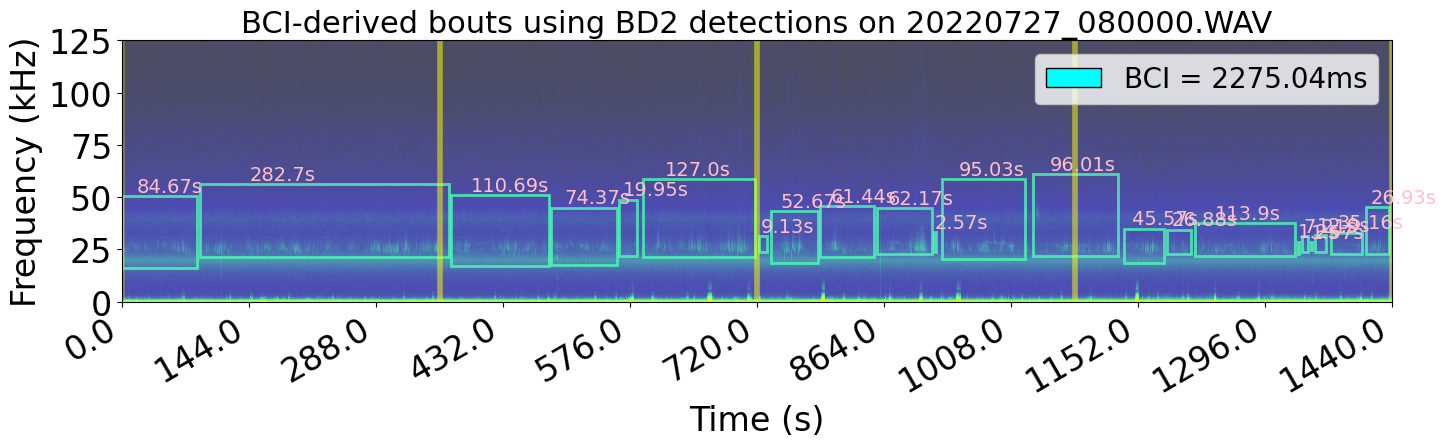

In [29]:
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

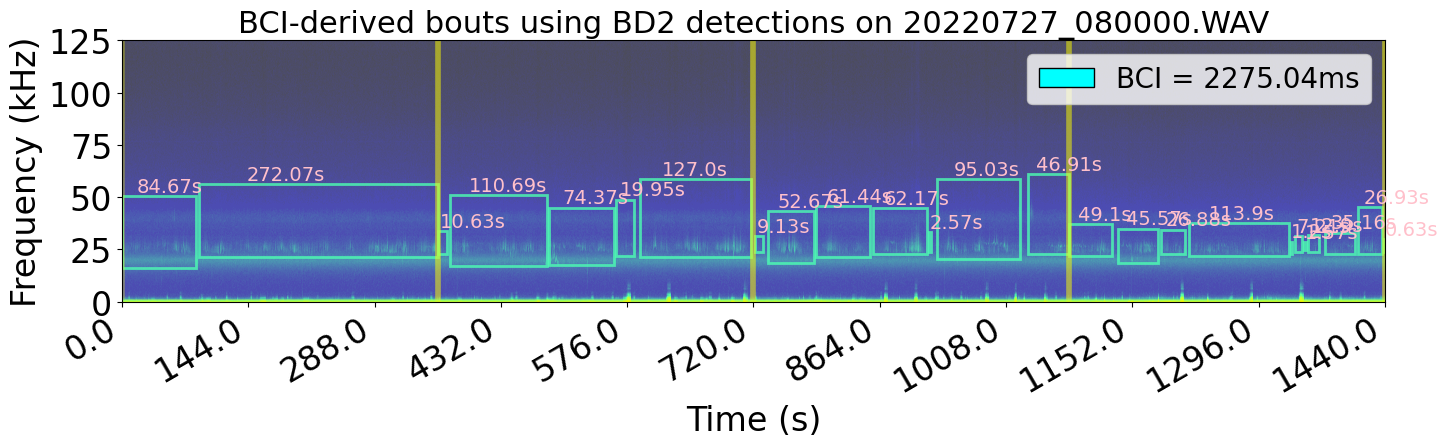

In [30]:
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts_mod)

In [33]:
plot_bouts_mod

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
7024,2022-07-27 08:00:00.053500,2022-07-27 08:01:24.725900000,0.0535,84.7259,0.0535,84.7259,16015.0,50519.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,476,0 days 00:01:24.672400,84.672400
7025,2022-07-27 08:01:27.926500,2022-07-27 08:06:00.000000000,87.9265,360.0000,87.9265,359.8742,21171.0,56240.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,1368,0 days 00:04:32.073500,272.073500
7026,2022-07-27 08:06:00.000000,2022-07-27 08:06:10.630700000,0.0000,10.6307,360.1075,370.6307,22890.0,33613.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,40,0 days 00:00:10.630700,10.630700
7027,2022-07-27 08:06:13.479500,2022-07-27 08:08:04.170600000,13.4795,124.1706,373.4795,484.1706,16875.0,51088.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,537,0 days 00:01:50.691100,110.691100
7028,2022-07-27 08:08:06.791500,2022-07-27 08:09:21.159700000,126.7915,201.1597,486.7915,561.1597,17734.0,45022.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,319,0 days 00:01:14.368200,74.368200
7029,2022-07-27 08:09:23.683500,2022-07-27 08:09:43.636500000,203.6835,223.6365,563.6835,583.6365,22031.0,48846.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,80,0 days 00:00:19.953000,19.953000
7030,2022-07-27 08:09:50.615500,2022-07-27 08:11:57.616000000,230.6155,357.6160,590.6155,717.6160,21171.0,58483.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,637,0 days 00:02:07.000500,127.000500
7031,2022-07-27 08:12:01.809500,2022-07-27 08:12:10.935100000,1.8095,10.9351,721.8095,730.9351,23750.0,31457.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,25,0 days 00:00:09.125600,9.125600
7032,2022-07-27 08:12:16.317500,2022-07-27 08:13:08.985500000,16.3175,68.9855,736.3175,788.9855,18593.0,43523.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,219,0 days 00:00:52.668000,52.668000
7033,2022-07-27 08:13:11.314500,2022-07-27 08:14:12.753800000,71.3145,132.7538,791.3145,852.7538,21171.0,45766.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,245,0 days 00:01:01.439300,61.439300


In [32]:
plot_bouts

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
6858,2022-07-27 08:00:00.053500,2022-07-27 08:01:24.725900000,0.0535,84.7259,0.0535,84.7259,16015.0,50519.0,LF,2022-07-27 08:00:00,2022-07-27 08:00:00,476,0 days 00:01:24.672400,84.672400
6859,2022-07-27 08:01:27.926500,2022-07-27 08:06:10.630700000,87.9265,10.6307,87.9265,370.6307,21171.0,56240.0,LF,2022-07-27 08:00:00,2022-07-27 08:06:00,1406,0 days 00:04:42.704200,282.704200
6860,2022-07-27 08:06:13.479500,2022-07-27 08:08:04.170600000,13.4795,124.1706,373.4795,484.1706,16875.0,51088.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,537,0 days 00:01:50.691100,110.691100
6861,2022-07-27 08:08:06.791500,2022-07-27 08:09:21.159700000,126.7915,201.1597,486.7915,561.1597,17734.0,45022.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,319,0 days 00:01:14.368200,74.368200
6862,2022-07-27 08:09:23.683500,2022-07-27 08:09:43.636500000,203.6835,223.6365,563.6835,583.6365,22031.0,48846.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,80,0 days 00:00:19.953000,19.953000
6863,2022-07-27 08:09:50.615500,2022-07-27 08:11:57.616000000,230.6155,357.6160,590.6155,717.6160,21171.0,58483.0,LF,2022-07-27 08:06:00,2022-07-27 08:06:00,637,0 days 00:02:07.000500,127.000500
6864,2022-07-27 08:12:01.809500,2022-07-27 08:12:10.935100000,1.8095,10.9351,721.8095,730.9351,23750.0,31457.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,25,0 days 00:00:09.125600,9.125600
6865,2022-07-27 08:12:16.317500,2022-07-27 08:13:08.985500000,16.3175,68.9855,736.3175,788.9855,18593.0,43523.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,219,0 days 00:00:52.668000,52.668000
6866,2022-07-27 08:13:11.314500,2022-07-27 08:14:12.753800000,71.3145,132.7538,791.3145,852.7538,21171.0,45766.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,245,0 days 00:01:01.439300,61.439300
6867,2022-07-27 08:14:15.777500,2022-07-27 08:15:17.951800000,135.7775,197.9518,855.7775,917.9518,22890.0,44685.0,LF,2022-07-27 08:12:00,2022-07-27 08:12:00,343,0 days 00:01:02.174300,62.174300
